In [902]:
# User-defined libraries
from utils.util_functions import *
from rpeak_detection.detectors import *
import os, psutil
from scipy.signal import butter, lfilter, filtfilt
from scipy import signal

In [ ]:
# Load all open source clean ECG

In [7]:
ds1 =  [101, 106, 108, 109, 112, 114, 115, 116, 118, 119, 122, 124, 201, 203, 205, 207, 208, 209, 215, 220, 223, 230]
ds2 = [100, 103, 105, 111, 113, 117, 121, 123, 200, 202, 210, 212, 213, 214, 219, 221, 222, 228, 231, 232, 233, 234]

os.chdir('/home/cbn-gpu08/Docker/R/ECG/mitdb/signal/')
file_names_signal = [str(w) + '.npy' for w in ds1]
file_names_anno = [str(w) + '_annotation_original.csv' for w in ds1]

ds1_signals = np.array([np.load(name) for name in file_names_signal])
ds1_signals = [ds1_signals[i][:,0] for i in range(len(ds1_signals))]
os.chdir('/home/cbn-gpu08/Docker/R/ECG/mitdb/annotation/')
ds1_annos = np.array([pd.read_csv(name) for name in file_names_anno])
# ds1_signals = [calc_lp(ds1_signals[i], 8, 2) for i in range(len(ds1_signals))]

os.chdir('/home/cbn-gpu08/Docker/R/ECG/mitdb/signal/')
file_names_signal = [str(w) + '.npy' for w in ds2]
file_names_anno = [str(w) + '_annotation_original.csv' for w in ds2]

ds2_signals = np.array([np.load(name) for name in file_names_signal])
ds2_signals = [ds2_signals[i][:,0] for i in range(len(ds2_signals))]
os.chdir('/home/cbn-gpu08/Docker/R/ECG/mitdb/annotation/')
if len(file_names_anno) > 1:
    ds2_annos = np.array([pd.read_csv(name) for name in file_names_anno])
else:
    ds2_annos = [pd.read_csv(file_names_anno[0]) ]
# ds2_signals = [calc_lp(ds2_signals[i], 8, 2) for i in range(len(ds2_signals))]
clear_output()

os.chdir('/home/cbn-gpu08/Docker/R/ECG/qt/signal/')
file_names_signal = glob.glob('*.npy')
file_names_signal.sort()

qt_signals = np.array([np.load(name) for name in file_names_signal])
qt_signals = [qt_signals[i][:,0] for i in range(len(qt_signals))]
os.chdir('/home/cbn-gpu08/Docker/R/ECG/qt/annotation/')
file_names_anno = [f for f in os.listdir() if re.search('_original', f)]
file_names_anno.sort()
qt_annos = [pd.read_csv(name) for name in file_names_anno]
# qt_signals = [calc_lp(qt_signals[i], 8, 2) for i in range(len(qt_signals))]

clear_output()

In [ ]:
# Create 3 seconds input by sampling rate

In [589]:
# This function creates and saves both of the 3 seconds signals and its FFT coefficients
# The shape of the result is (the number of 3 seconds diviend) x (seconds * sampling rate)
def create_input_noise_detection(file_name, sRate_from, sRate_to, seconds, path_load, path_save):

    os.chdir(path_load)
    df_signal = np.load(file_name)
    df_signal = df_signal[:,0]

    os.chdir(path_save)
    rest = (len(df_signal) % int(sRate_from * seconds))
    if rest != 0:
        y = df_signal[:-rest]
    else:
        y = df_signal
        
    y = np.reshape(y, (int(len(y)/int(sRate_from * seconds)), int(sRate_from * seconds)))
    y = signal.resample(y, int(sRate_to * seconds), axis = 1)
    ma = y.max()
    mi = y.min()
    ran = np.abs(ma - mi)
    y = y/ran
    ffts = fft(y)
    ffts = np.array(np.abs(ffts))
    y = np.expand_dims(y, 1)
    ffts = np.expand_dims(ffts, 1)

    np.save(file_name[:-4] + '_signal_' + str(seconds) + 'seconds.npy', y)
    np.save(file_name[:-4] + '_fft_' + str(seconds) + 'seconds.npy', ffts)
    
    return y, ffts

In [584]:
# An example to create 3 seconds deep learning input
# 360Hz to 250Hz, 3 seconds input
# The first path means the path for loading, and the second path is to save the 3s input
x, y = create_input_noise_detection('201.npy', 360, 250, 3, 
                             '/home/cbn-gpu08/Docker/Python/ECG/pretraining_sets/mitdb',
                             '/home/cbn-gpu08/Docker/Python/ECG/pretraining_sets/3s_inputs')

os.chdir('/home/cbn-gpu08/Docker/Python/ECG/pretraining_sets/3s_inputs')
x = np.load('201_signal_3seconds.npy')


In [590]:
# Create all MITBIH input for training pretrained model for noise classification
os.chdir('/home/cbn-gpu08/Docker/Python/ECG/pretraining_sets/mitdb')
file_names = os.listdir()
mit_signals = []
mit_ffts = []

for name in file_names:
    x, y = create_input_noise_detection(name, 360, 250, 3, 
                             '/home/cbn-gpu08/Docker/Python/ECG/pretraining_sets/mitdb',
                             '/home/cbn-gpu08/Docker/Python/ECG/pretraining_sets/3s_inputs')
    mit_signals.append(x)
    mit_ffts.append(y)
                             

In [591]:
# Reshaping the integrated signals
mit_signals = np.array(mit_signals)
mit_signals = np.reshape(mit_signals, (-1, 1, 750))

mit_ffts = np.array(mit_ffts)
mit_ffts = np.reshape(mit_ffts, (-1, 1, 750))

In [592]:
# Functino for generating fake noise signals
# signal_array: original clean signal 
# num_z: the number of Gaussian noise signals to be created
def create_fake_noise(signal_array, num_z):
    
    num1 = int(len(signal_array)/2)
    num2 = int(len(signal_array)/4)
    signal_array = signal_array[0:(num1+2*num2),:,:]
    
    fake_signals1 = []
    fake_signals2 = []
    highs = random.choices(range(6, 9), weights=[0.5, 0.25, 0.25],  k = num1)
    lows = random.choices(range(4, 6), weights=[0.5, 0.5],  k = num1)
    
    for i in range(num1):
        fake_signals1.append(calc_lp(signal_array[i,0,:], highs[i], lows[i]))
    
    for i in range(num1, num1+num2):
        num = random.choice(range(5, 50))
        y = calc_lp(signal_array[i,0,:], 2, 1)
        z = y.copy()
        for k in range(num):
            step = random.choice(range(10, 100))
            z = z+np.roll(y, step)
        fake_signals2.append(normalize(z + calc_lp(signal_array[i,0,:], 7, 6)))
    fake_signals = fake_signals1 + fake_signals2   
    fake_signals = np.array(fake_signals).reshape(-1, 1, 750)
    
    z_signals = np.random.standard_normal(size=(num_z, 750))
    y = np.concatenate([np.array([1,2,3,4],), np.arange(1, 150, 5)])
    x = np.random.choice(y, num_z, replace=True)
    scaled_signals = []
    for i in range(num_z):
        scaled_signals.append(z_signals[i]/x[i])

    scaled_signals = np.array(scaled_signals)
    z_signals = scaled_signals.reshape(-1, 1, 750)
        
    fake_signals = np.vstack((fake_signals, z_signals))
    return fake_signals

In [593]:
# Create both of fake noise signal and its FFT coefficients
noise_signals = create_fake_noise(mit_signals, 2000)
noise_ffts = fft(noise_signals)
noise_ffts = np.array(np.abs(noise_ffts))

In [594]:
# Functions for training and testing noise classification model
def create_datasets(data, target, train_size, valid_pct=0.2, seed=None):

    raw, fft = data
    raw[np.isnan(raw)] = 0
    fft[np.isnan(fft)] = 0
    assert len(raw) == len(fft)
    sz = train_size
    idx = np.arange(sz)
    trn_idx, val_idx = train_test_split(
        idx, test_size=valid_pct, random_state=seed)
    trn_ds = TensorDataset(
        torch.tensor(raw[:sz][trn_idx]).float(), 
        torch.tensor(fft[:sz][trn_idx]).float(), 
        torch.tensor(target[:sz][trn_idx]).long())
    val_ds = TensorDataset(
        torch.tensor(raw[:sz][val_idx]).float(), 
        torch.tensor(fft[:sz][val_idx]).float(), 
        torch.tensor(target[:sz][val_idx]).long())
    tst_ds = TensorDataset(
        torch.tensor(raw[sz:]).float(), 
        torch.tensor(fft[sz:]).float(), 
        torch.tensor(target[sz:]).long())
    return trn_ds, val_ds, tst_ds

def create_loaders(data, bs=128, jobs=0):
    trn_ds, val_ds, tst_ds = data
    trn_dl = DataLoader(trn_ds, batch_size=bs, shuffle=True, num_workers=jobs)
    val_dl = DataLoader(val_ds, batch_size=bs, shuffle=False, num_workers=jobs)
    tst_dl = DataLoader(tst_ds, batch_size=bs, shuffle=False, num_workers=jobs)
    return trn_dl, val_dl, tst_dl

def create_testset(data, target):

    raw, fft = data
    raw[np.isnan(raw)] = 0
    fft[np.isnan(fft)] = 0
    assert len(raw) == len(fft)

    tst_ds = TensorDataset(
        torch.tensor(raw).float(), 
        torch.tensor(fft).float(), 
        torch.tensor(target).long())
    return tst_ds

def create_loaders_test(data, bs=128, jobs=0):
    tst_ds = data
    tst_dl = DataLoader(tst_ds, batch_size=bs, shuffle=False, num_workers=jobs)
    return tst_dl

def calc_lp(signal, low, high):
    n = len(signal)
    approxi = pywt.downcoef('a', signal, 'db4', level=low)
    baseline = pywt.upcoef('a', approxi, 'db4', level=low, take=n)
    
    approxi = pywt.downcoef('a', signal, 'db4', level=high)
    upper = pywt.upcoef('a', approxi, 'db4', level=high, take=n)
    return upper - baseline

In [1088]:
sig = np.concatenate((mit_signals, noise_signals), axis = 0)
sig = sig.reshape(-1, 1, 750)
ffts = np.concatenate((mit_ffts, noise_ffts), axis = 0)
anno = np.array(list(np.zeros(len(mit_signals))) + list(np.ones(len(noise_signals))))

idx = list(range(sig.shape[0]))
random.shuffle(idx)
sig = sig[idx]
ffts = ffts[idx]
anno = anno[idx]

In [1090]:
train_dataset,_,_= create_datasets((sig,ffts), anno, 45000, 0.2, seed=2021)
datasets = create_datasets((sig,ffts), anno, 45000, 0.2, seed=2021)
trn_dl, val_dl, tst_dl = create_loaders(datasets, bs=128)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [1091]:
# Networks
class _SepConv1d(nn.Module):
    """A simple separable convolution implementation.
    
    The separable convlution is a method to reduce number of the parameters 
    in the deep learning network for slight decrease in predictions quality.
    """
    def __init__(self, ni, no, kernel, stride, pad):
        super().__init__()
        self.depthwise = nn.Conv1d(ni, ni, kernel, stride, padding=pad, groups=ni)
        self.pointwise = nn.Conv1d(ni, no, kernel_size=1)

    def forward(self, x):
        return self.pointwise(self.depthwise(x))

class SepConv1d(nn.Module):
    """Implementes a 1-d convolution with 'batteries included'.
    
    The module adds (optionally) activation function and dropout layers right after
    a separable convolution layer.
    """
    def __init__(self, ni, no, kernel, stride, pad, drop=None,
                 activ=lambda: nn.ReLU(inplace=True)):
    
        super().__init__()
        assert drop is None or (0.0 < drop < 1.0)
        layers = [_SepConv1d(ni, no, kernel, stride, pad)]
        if activ:
            layers.append(activ())
        if drop is not None:
            layers.append(nn.Dropout(drop))
        self.layers = nn.Sequential(*layers)
        
    def forward(self, x): 
        return self.layers(x)

class Flatten(nn.Module):
    """Converts N-dimensional tensor into 'flat' one."""

    def __init__(self, keep_batch_dim=True):
        super().__init__()
        self.keep_batch_dim = keep_batch_dim

    def forward(self, x):
        if self.keep_batch_dim:
            return x.view(x.size(0), -1)
        return x.view(-1)
    
class Classifier(nn.Module):
    def __init__(self, raw_ni, fft_ni, no, drop=.5):
        super().__init__()

        self.raw = nn.Sequential(
            SepConv1d(raw_ni,  32, 8, 2, 3, drop=drop),
            SepConv1d(    32,  64, 8, 4, 2, drop=drop),
            SepConv1d(    64, 128, 8, 4, 2, drop=drop),
            SepConv1d(   128, 256, 8, 4, 2),
            Flatten(),
            nn.Dropout(drop), nn.Linear(1280, 64), nn.ReLU(inplace=True),
            nn.Dropout(drop), nn.Linear( 64, 64), nn.ReLU(inplace=True))
        
        self.fft = nn.Sequential(
            SepConv1d(fft_ni,  32, 8, 2, 4, drop=drop),
            SepConv1d(    32,  64, 8, 2, 4, drop=drop),
            SepConv1d(    64, 128, 8, 4, 4, drop=drop),
            SepConv1d(   128, 128, 8, 4, 4, drop=drop),
            SepConv1d(   128, 256, 8, 2, 3),
            Flatten(),
            nn.Dropout(drop), nn.Linear(1536, 64), nn.ReLU(inplace=True),
            nn.Dropout(drop), nn.Linear( 64, 64), nn.ReLU(inplace=True))
        
        self.out = nn.Sequential(
            nn.Linear(128, 64), nn.ReLU(inplace=True), nn.Linear(64, no))
        
    def forward(self, t_raw, t_fft):
    
        raw_out = self.raw(t_raw)
        #print("raw_out", raw_out.shape)
        fft_out = self.fft(t_fft)
        #print("fft_out", fft_out.shape)
        t_in = torch.cat([raw_out, fft_out], dim=1)
        out = self.out(t_in)
        return out

In [1093]:
print(np.unique(anno, return_counts = True))
trn_sz = 45000

os.chdir('/home/cbn-gpu08/Docker/R/ECG/mitdb/models/')
raw_feat = sig.shape[1]
fft_feat = ffts.shape[1]

lr = 0.0001
n_epochs = 500
iterations_per_epoch = len(trn_dl)
num_classes = 2
best_acc = 0
patience, trials = 15, 0
base = 1
step = 2
loss_history = []
acc_history = []

model = Classifier(raw_feat, fft_feat, num_classes).to(device)
criterion = nn.CrossEntropyLoss(reduction='sum')
opt = optim.Adam(model.parameters(), lr=lr)


for epoch in range(1, n_epochs + 1):

    model.train()
    epoch_loss = 0
    for i, batch in enumerate(trn_dl):
        x_raw, x_fft, y_batch = [t.to(device) for t in batch]
        opt.zero_grad()
        out = model(x_raw, x_fft)
        loss = criterion(out, y_batch)
        epoch_loss += loss.item()
        loss.backward()
        opt.step()

    epoch_loss /= trn_sz
    loss_history.append(epoch_loss)

    model.eval()
    correct, total = 0, 0
    for batch in val_dl:
        x_raw, x_fft, y_batch = [t.to(device) for t in batch]
        out = model(x_raw, x_fft)
        preds = F.log_softmax(out, dim=1).argmax(dim=1)
        total += y_batch.size(0)
        correct += (preds == y_batch).sum().item()

    acc = correct / total
    acc_history.append(acc)

    if epoch % base == 0:
        print(f'Epoch: {epoch:3d}. Loss: {epoch_loss:.4f}. Acc.: {acc:2.2%}')
        base *= step

    if acc > best_acc:
        trials = 0
        best_acc = acc
        torch.save(model.state_dict(), 'trying_0614')
        print(f'Epoch {epoch} best model saved with accuracy: {best_acc:2.2%}')
    else:
        trials += 1
        if trials >= patience:
            print(f'Early stopping on epoch  {epoch}')
            break

print('Done!')

(array([0., 1.]), array([26444, 21833]))
Epoch:   1. Loss: 0.5511. Acc.: 55.37%
Epoch 1 best model saved with accuracy: 55.37%
Epoch:   2. Loss: 0.2333. Acc.: 97.79%
Epoch 2 best model saved with accuracy: 97.79%
Epoch 3 best model saved with accuracy: 99.54%
Epoch:   4. Loss: 0.0437. Acc.: 99.72%
Epoch 4 best model saved with accuracy: 99.72%
Epoch 5 best model saved with accuracy: 99.80%
Epoch 6 best model saved with accuracy: 99.81%
Epoch 7 best model saved with accuracy: 99.84%
Epoch:   8. Loss: 0.0229. Acc.: 99.87%
Epoch 8 best model saved with accuracy: 99.87%
Epoch 11 best model saved with accuracy: 99.88%
Epoch:  16. Loss: 0.0130. Acc.: 99.88%
Epoch 18 best model saved with accuracy: 99.89%
Epoch 21 best model saved with accuracy: 99.90%
Epoch:  32. Loss: 0.0092. Acc.: 99.90%
Epoch 34 best model saved with accuracy: 99.91%
Epoch 37 best model saved with accuracy: 99.92%
Epoch 48 best model saved with accuracy: 99.93%
Epoch 57 best model saved with accuracy: 99.94%
Epoch:  64. L

In [ ]:
# Create test inputs for noise classification model
# Here we should make the same shape of training examples for ATsens signals

In [1095]:
def create_input_noise_detection_at(file_name, sRate_from, sRate_to, seconds, path_load, path_save):

    os.chdir(path_load)
    df_signal = np.load(file_name)
    df_signal = df_signal[:,0]

    os.chdir(path_save)
    rest = (len(df_signal) % int(sRate_from * seconds))
    if rest != 0:
        y = df_signal[:-rest]
    else:
        y = df_signal
        
    y = np.reshape(y, (int(len(y)/int(sRate_from * seconds)), int(sRate_from * seconds)))
    y = signal.resample(y, int(sRate_to * seconds), axis = 1)

    ffts = fft(y)
    ffts = np.array(np.abs(ffts))
    y = np.expand_dims(y, 1)
    ffts = np.expand_dims(ffts, 1)

    np.save(file_name[:-4] + '_signal_' + str(seconds) + 'seconds.npy', y)
    np.save(file_name[:-4] + '_fft_' + str(seconds) + 'seconds.npy', ffts)
    
    return y, ffts

In [1096]:
# Create 3 seconds input
test, test_fft = create_input_noise_detection_at('AMC4.npy', 300, 250, 3, 
                             '/home/cbn-gpu08/Docker/Python/ECG/data',
                             '/home/cbn-gpu08/Docker/Python/ECG/pretraining_sets/')

testset = create_testset((test, test_fft), np.zeros(len(test)))
tst_dl = create_loaders_test(testset, bs=128, jobs=0)

In [1129]:
# Prediction
os.chdir('/home/cbn-gpu08/Docker/R/ECG/mitdb/models/')
model.load_state_dict(torch.load('trying_0613'))
model.eval()
pred = []
correct, total = 0, 0
true = []
test_signal = []
for batch in tst_dl:
    x_raw, x_fft, y_batch = [t.to(device) for t in batch]
    out = model(x_raw, x_fft)
    preds = F.log_softmax(out, dim=1).argmax(dim=1)
    pred.append(preds.tolist())
    true.append(y_batch.tolist())
    test_signal.append(x_raw.tolist())
    total += y_batch.size(0)
    correct += (preds == y_batch).sum().item()

In [1130]:
pred = list(chain.from_iterable(pred))
true = list(chain.from_iterable(true))
test_signal = list(chain.from_iterable(test_signal))
test_signal = list(chain.from_iterable(test_signal))

True: Normal
Pred: Normal


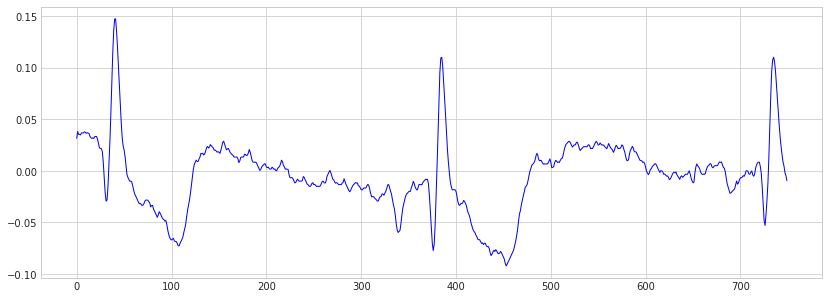

In [1151]:
i = random.choice(np.where(np.array(pred) == 0)[0])

if true[i] == 1:
    print('True: ' + 'Noise')
else:
    print('True: ' +'Normal')
    
if pred[i] == 1:
    print('Pred: ' +'Noise')
else:
    print('Pred: ' +'Normal')
    
xs = range(len(test_signal[i]))
ys = test_signal[i]

plt.figure(figsize=(14, 5))
plt.plot(xs, ys, color = 'blue', linewidth = 1)
